## 1. Montaje de Google Drive, definición de rutas y librerias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta base de tus datasets (ajusta si lo tienes en otra carpeta)
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks"

IMAGES_PATH = f"{BASE_PATH}/pet_dataset_LB5"
MASKS_PATH  = f"{BASE_PATH}/irregular_masks"

print("Carpetas configuradas correctamente:")
print(" - Imágenes:", IMAGES_PATH)
print(" - Máscaras:", MASKS_PATH)

Mounted at /content/drive
Carpetas configuradas correctamente:
 - Imágenes: /content/drive/MyDrive/Colab Notebooks/pet_dataset_LB5
 - Máscaras: /content/drive/MyDrive/Colab Notebooks/irregular_masks


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


## 2. Implementación del Dataset de Inpainting

In [9]:
# ============================================================
# 3. Dataset de Inpainting con máscaras irregulares
# ============================================================

class InpaintingDataset(Dataset):
    def __init__(self, images_dir, masks_dir, img_size=256):
        self.img_paths = glob(os.path.join(images_dir, "*.jpg"))
        self.mask_paths = glob(os.path.join(masks_dir, "*.png"))
        self.img_size = img_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):

        # ------------------------------
        # 1. Cargar imagen RGB completa
        # ------------------------------
        img = Image.open(self.img_paths[idx]).convert("RGB")
        img = img.resize((self.img_size, self.img_size))
        img_np = np.array(img) / 255.0   # [0,1]

        # ------------------------------
        # 2. Seleccionar máscara aleatoria
        # ------------------------------
        mask_path = random.choice(self.mask_paths)
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((self.img_size, self.img_size))
        mask_np = np.array(mask) / 255.0
        mask_np = (mask_np > 0.5).astype(np.float32)

        # máscara invertida = huecos (1 = hueco)
        mask_inv = 1 - mask_np

        # ------------------------------
        # 3. Aplicar máscara → Input con huecos
        # ------------------------------
        damaged_np = img_np * mask_np[:, :, None]

        # ------------------------------
        # 4. Convertir a tensores
        # ------------------------------
        img_tensor      = torch.tensor(img_np).permute(2,0,1).float()
        damaged_tensor  = torch.tensor(damaged_np).permute(2,0,1).float()
        mask_tensor     = torch.tensor(mask_inv).unsqueeze(0).float()

        return damaged_tensor, mask_tensor, img_tensor


## 3. Crear Data Loaders

In [10]:
# ============================================================
# 4. Crear Dataloader de Entrenamiento y Prueba
# ============================================================

dataset = InpaintingDataset(IMAGES_PATH, MASKS_PATH)

# 85% train — 15% test
train_size = int(0.85 * len(dataset))
test_size  = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False)

len(train_dataset), len(test_dataset)


(565, 100)

# 4. Visualización de Dataset

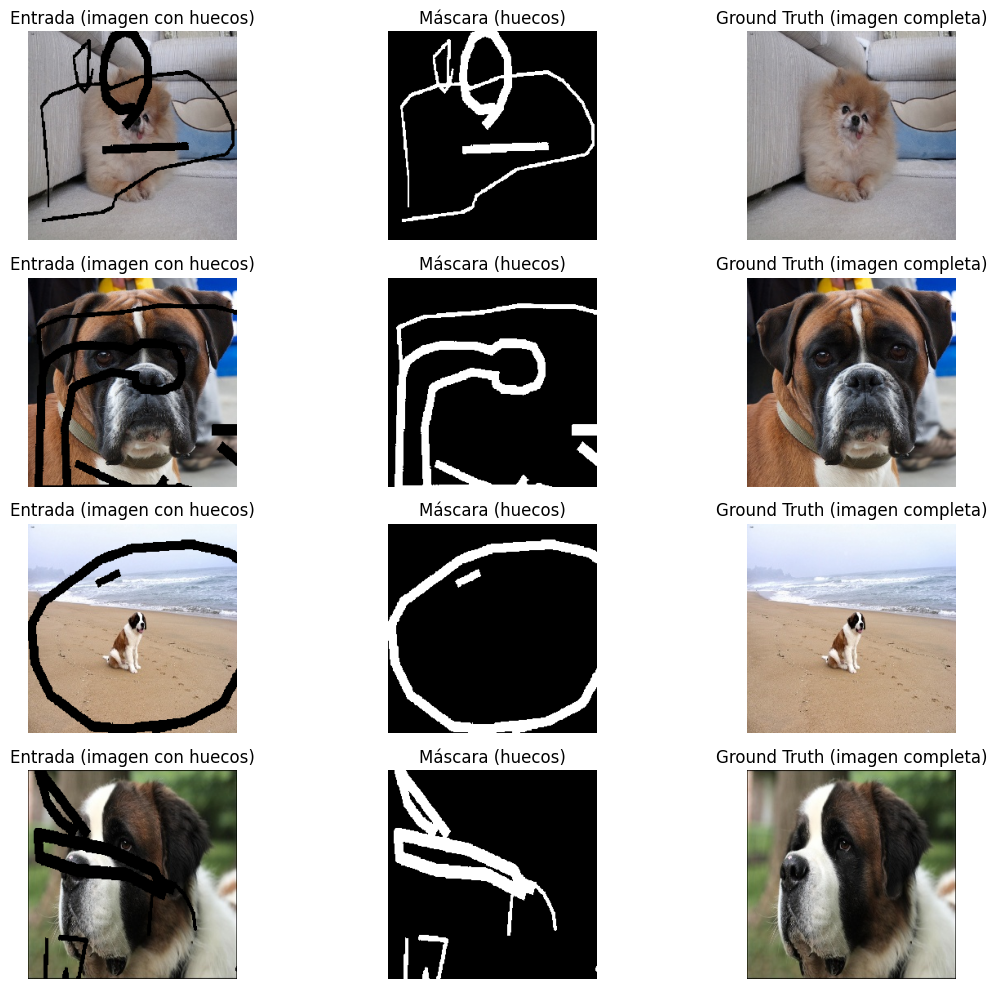

In [11]:
# ============================================================
# 5. Visualización del Dataset
# ============================================================

def show_samples(dataloader, n=4):
    """
    Muestra n ejemplos del dataloader:
    - Imagen dañada (input)
    - Máscara invertida (huecos)
    - Imagen completa (GT)
    """

    damaged_batch, mask_batch, gt_batch = next(iter(dataloader))

    plt.figure(figsize=(12, 10))

    for i in range(n):

        # ---------------------------
        # Imagen dañada (entrada)
        # ---------------------------
        plt.subplot(n, 3, i*3 + 1)
        damaged_img = damaged_batch[i].permute(1,2,0).numpy()
        plt.imshow(np.clip(damaged_img, 0, 1))
        plt.title("Entrada (imagen con huecos)")
        plt.axis("off")

        # ---------------------------
        # Máscara invertida
        # ---------------------------
        plt.subplot(n, 3, i*3 + 2)
        mask_img = mask_batch[i].squeeze(0).numpy()
        plt.imshow(mask_img, cmap="gray")
        plt.title("Máscara (huecos)")
        plt.axis("off")

        # ---------------------------
        # Ground Truth
        # ---------------------------
        plt.subplot(n, 3, i*3 + 3)
        gt_img = gt_batch[i].permute(1,2,0).numpy()
        plt.imshow(np.clip(gt_img, 0, 1))
        plt.title("Ground Truth (imagen completa)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Mostrar ejemplos del dataset
show_samples(train_loader, n=4)


# 5. Implementación de la U-Net

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [13]:
class DoubleConv(nn.Module):
    """
    Bloque: Conv2d -> ReLU -> Conv2d -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super(UNet, self).__init__()

        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        # Capa final: 3 canales (RGB)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.pool1(x1)

        x3 = self.down2(x2)
        x4 = self.pool2(x3)

        x5 = self.down3(x4)
        x6 = self.pool3(x5)

        x7 = self.down4(x6)
        x8 = self.pool4(x7)

        # Bottleneck
        x9 = self.bottleneck(x8)

        # Decoder con skip connections
        x = self.up4(x9)
        x = torch.cat([x, x7], dim=1)
        x = self.conv4(x)

        x = self.up3(x)
        x = torch.cat([x, x5], dim=1)
        x = self.conv3(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)

        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv1(x)

        # Salida
        x = self.final_conv(x)
        x = torch.sigmoid(x)   # aseguramos rango [0,1]

        return x

# Instanciar modelo
model = UNet(in_channels=4, out_channels=3).to(device)
print("Modelo U-Net creado.")


Modelo U-Net creado.


# 6. Función de pérdida, optimizador y PSNR

In [14]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def compute_psnr(pred, target, max_val=1.0):
    """
    Calcula PSNR promedio por batch.
    """
    mse = torch.mean((pred - target) ** 2, dim=[1, 2, 3])
    # evitar división entre 0
    mse = torch.clamp(mse, min=1e-8)
    psnr = 10 * torch.log10(max_val**2 / mse)
    return psnr.mean().item()


# 7. Loop de entrenamiento + validación

In [15]:
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
    # Fase de entrenamiento
    model.train()
    running_loss = 0.0

    for damaged, mask, gt in train_loader:
        damaged = damaged.to(device)
        mask    = mask.to(device)
        gt      = gt.to(device)

        # Concatenar imagen dañada + máscara → 4 canales
        inp = torch.cat([damaged, mask], dim=1)

        optimizer.zero_grad()
        output = model(inp)

        loss = criterion(output, gt)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * damaged.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Fase de validación
    model.eval()
    val_psnr = 0.0

    with torch.no_grad():
        for damaged, mask, gt in test_loader:
            damaged = damaged.to(device)
            mask    = mask.to(device)
            gt      = gt.to(device)

            inp = torch.cat([damaged, mask], dim=1)
            output = model(inp)

            val_psnr += compute_psnr(output, gt) * damaged.size(0)

    val_psnr = val_psnr / len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  "
          f"Train Loss: {train_loss:.4f}  "
          f"Val PSNR: {val_psnr:.2f} dB")


Epoch [1/20]  Train Loss: 0.1169  Val PSNR: 20.63 dB
Epoch [2/20]  Train Loss: 0.0639  Val PSNR: 23.42 dB
Epoch [3/20]  Train Loss: 0.0477  Val PSNR: 24.51 dB
Epoch [4/20]  Train Loss: 0.0407  Val PSNR: 25.78 dB
Epoch [5/20]  Train Loss: 0.0355  Val PSNR: 25.74 dB
Epoch [6/20]  Train Loss: 0.0341  Val PSNR: 26.96 dB
Epoch [7/20]  Train Loss: 0.0317  Val PSNR: 26.64 dB
Epoch [8/20]  Train Loss: 0.0318  Val PSNR: 27.34 dB
Epoch [9/20]  Train Loss: 0.0288  Val PSNR: 27.82 dB
Epoch [10/20]  Train Loss: 0.0338  Val PSNR: 26.94 dB
Epoch [11/20]  Train Loss: 0.0285  Val PSNR: 27.83 dB
Epoch [12/20]  Train Loss: 0.0240  Val PSNR: 27.91 dB
Epoch [13/20]  Train Loss: 0.0266  Val PSNR: 26.93 dB
Epoch [14/20]  Train Loss: 0.0574  Val PSNR: 27.73 dB
Epoch [15/20]  Train Loss: 0.0234  Val PSNR: 28.44 dB
Epoch [16/20]  Train Loss: 0.0219  Val PSNR: 28.82 dB
Epoch [17/20]  Train Loss: 0.0217  Val PSNR: 29.25 dB
Epoch [18/20]  Train Loss: 0.0210  Val PSNR: 26.92 dB
Epoch [19/20]  Train Loss: 0.0213  Va

# 8. Visualización final de resultados

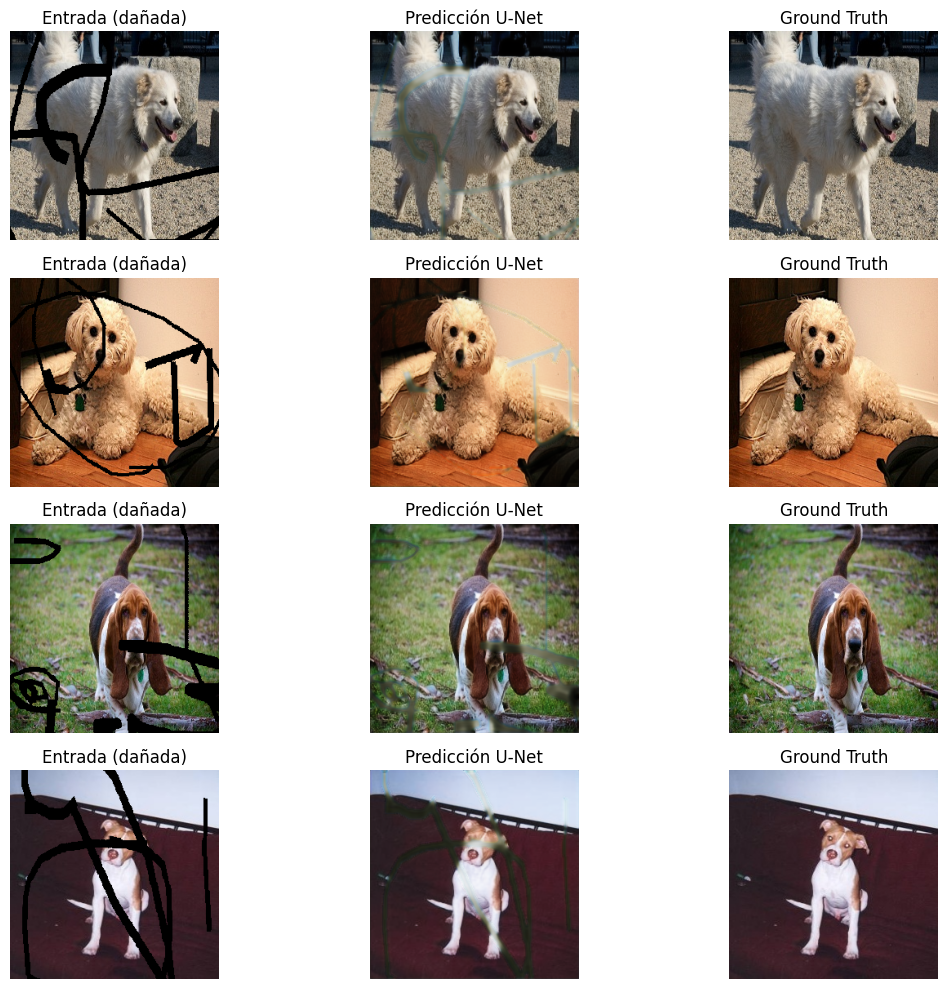

In [16]:
def show_model_results(model, dataloader, n=4):
    """
    Muestra n resultados del modelo:
    - Entrada (imagen con huecos)
    - Predicción (U-Net)
    - Ground Truth (original)
    """

    model.eval()
    damaged_batch, mask_batch, gt_batch = next(iter(dataloader))

    damaged_batch = damaged_batch.to(device)
    mask_batch    = mask_batch.to(device)
    gt_batch      = gt_batch.to(device)

    with torch.no_grad():
        inp = torch.cat([damaged_batch, mask_batch], dim=1)
        pred_batch = model(inp)

    plt.figure(figsize=(12, 10))

    for i in range(n):

        # ---------------------------
        # Entrada
        # ---------------------------
        plt.subplot(n, 3, i*3 + 1)
        damaged_img = damaged_batch[i].cpu().permute(1,2,0).numpy()
        plt.imshow(np.clip(damaged_img, 0, 1))
        plt.title("Entrada (dañada)")
        plt.axis("off")

        # ---------------------------
        # Predicción
        # ---------------------------
        plt.subplot(n, 3, i*3 + 2)
        pred_img = pred_batch[i].cpu().permute(1,2,0).numpy()
        plt.imshow(np.clip(pred_img, 0, 1))
        plt.title("Predicción U-Net")
        plt.axis("off")

        # ---------------------------
        # Ground Truth
        # ---------------------------
        plt.subplot(n, 3, i*3 + 3)
        gt_img = gt_batch[i].cpu().permute(1,2,0).numpy()
        plt.imshow(np.clip(gt_img, 0, 1))
        plt.title("Ground Truth")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Mostrar resultados del test set
show_model_results(model, test_loader, n=4)


# 9. Cálculo final del PSNR en el Test Set

In [17]:
def evaluate_psnr(model, dataloader):
    model.eval()
    total_psnr = 0.0
    total_items = 0

    with torch.no_grad():
        for damaged, mask, gt in dataloader:
            damaged = damaged.to(device)
            mask    = mask.to(device)
            gt      = gt.to(device)

            inp = torch.cat([damaged, mask], dim=1)
            pred = model(inp)

            batch_size = damaged.size(0)
            total_psnr += compute_psnr(pred, gt) * batch_size
            total_items += batch_size

    return total_psnr / total_items


final_psnr = evaluate_psnr(model, test_loader)
print(f"PSNR final en test set ≈ {final_psnr:.2f} dB")


PSNR final en test set ≈ 28.67 dB


# 10. imágenes finales

In [18]:
import os

SAVE_DIR = f"{BASE_PATH}/inpainting_results"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_results_for_report(model, dataloader, num_samples=6):
    model.eval()

    damaged_batch, mask_batch, gt_batch = next(iter(dataloader))
    damaged_batch = damaged_batch.to(device)
    mask_batch    = mask_batch.to(device)
    gt_batch      = gt_batch.to(device)

    with torch.no_grad():
        inp = torch.cat([damaged_batch, mask_batch], dim=1)
        pred_batch = model(inp)

    for i in range(num_samples):
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))

        axs[0].imshow(damaged_batch[i].cpu().permute(1,2,0).numpy())
        axs[0].set_title("Entrada dañada")
        axs[0].axis("off")

        axs[1].imshow(pred_batch[i].cpu().permute(1,2,0).numpy())
        axs[1].set_title("Predicción U-Net")
        axs[1].axis("off")

        axs[2].imshow(gt_batch[i].cpu().permute(1,2,0).numpy())
        axs[2].set_title("Ground Truth")
        axs[2].axis("off")

        plt.tight_layout()
        fig.savefig(f"{SAVE_DIR}/resultado_{i+1}.png")
        plt.close(fig)

    print(f"Imágenes guardadas en: {SAVE_DIR}")

# Ejecutar
save_results_for_report(model, test_loader, num_samples=6)


Imágenes guardadas en: /content/drive/MyDrive/Colab Notebooks/inpainting_results
